<div style="text-align:center; font-weight:bold; font-size:35px; line-height:1.0;">EDA: Sell Your House for More </div>

<figure style="margin-top:10px"><img src="https://www.racialequityalliance.org/wp-content/uploads/2016/10/assessors_social-1.jpg" />
<figcaption style="text-align:center; font-size:8px">source: https://www.racialequityalliance.org/jurisdictions/king-county-washington/assessors_social/</figcaption>
</figure>




# Initial Imports and Data Cleaning

## How can we get more money for our house in King County?

We are selling our house and would like to know which characteristics of a home can help improve the sale price.

In order to help answer this question, we have been provided a dataset of home sales in King County which occurred during the period of September 9, 2014 through January 10, 2015.

We will attempt to model sale prices based on the other data fields and then determine which characteristics lead to an increase in sale price.

## Our Dataset

The data was provided in a csv format.  There are 21,597 sales records and 21 columns.

Column Names and descriptions:
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Import Libraries and Custom Functions

The following code will import our custom functions from Mod1_Functions.py.

We also import pandas, numpy, matplotlib, seaborn, statsmodels, and scikit-learn.

In [1]:
from Mod1_Functions import *


## Import Raw Dataset

We import the csv data into a pandas dataframe by using `pandas.read_csv()`.

In [2]:
df_raw = pd.read_csv('kc_house_data.csv')

The code below shows the count of any data columns that are missing information.

In [3]:
missing = df_raw.shape[0] - df_raw.count()
print(missing[missing>0])

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


From above, we can see that `waterfront`, `view`, and `yr_renovated` are missing values.

`date` is formatted as an object type, instead of a date (datetime64).

`sqft_basement` is also formatted as an object type, when we would expect a number format.

Let's take a look at some scatter plots of each potential X variable compared to our target `'price'`.

The custom function below accepts inputs of a dataframe and the name of the column that is the target.  Additional parameters can also be passed through to adjust the formatting.

Warnings are printed for any variables that cannot immediately be graphed as numbers, due to their datatypes.

In [4]:
#scatter_y(df_raw, 'price', ncols=2, figsize=(16,45))


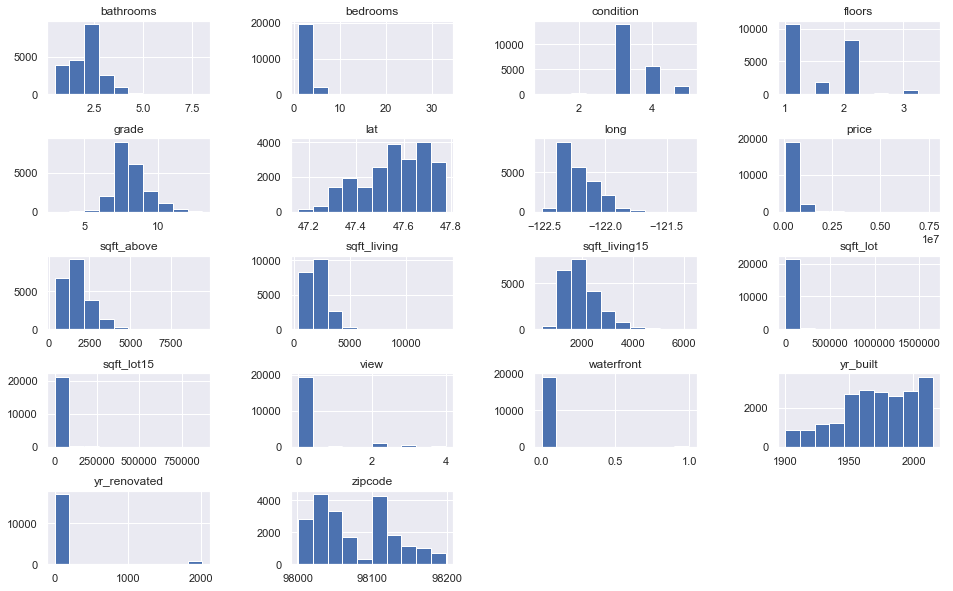

In [5]:
df_raw.iloc[:, 2:].hist(figsize  = [16, 10])
plt.subplots_adjust(wspace=0.5, hspace=0.6)

## Clean data using custom function

Our `clean_dataframe()` function takes in inputs of dataframe and a dictionary of adjustments.

We first set our `data_adjustments` dictionary to contain the fields we want to change as keys and a list of adjustments as dictionary values.

The parameters in the list are: \[datatype, value to replace, value to replace with, replacement array\]

    - datatype: must be a valid data type
    - value to replace: can be a single value string, integer, or np.nan
    - value to replace with: can be a single value or can be a list with strings containg other column names in dataframe (see replacement array below)
    - replacement array: contains a list of floats or integers, which are multiplied by the associated data field in the "value to replace with" list
    
The list items should be set to None for any parameters you do not wish to use.

We found some issues with the following data fields and decided to make some adjustments.

- `'date'` : Currently the date is formatted as a string and we would like to change it into a date (datetime64) so that we can use it in our model.


- `'bedrooms'` : There was one unusually high value of 33 bedrooms for one record.  We decided to replace that value with 3, based on the properties nearest neighbors by `'price'` and `'sqft_living'`.  It is also reasonable to assume that that the 33 was an accidental double-keystroke.


- `'waterfront'`: There were 2,376 missing values in this field, which we have replaced with 'missing'.  We don't know whether these records are on the waterfront or not, but it is a significant enough proportion of records (11%), so we don't want to make an assumption about whether they are on the waterfront and also don't want to exclude them from the dataset.

In [6]:
data_adjustments = {'date': ['datetime64', None, None, None],
                    'bedrooms': [None, 33, 3, None],
                    'waterfront': [str, np.nan, 'missing', None],
                    'view': [str, np.nan, 0, None],
                    'sqft_basement': [float, '?', ['sqft_living', 'sqft_above'], [1, -1]],
                    'floors': [None, 3.5, 3, None]
                   }

In [7]:
df_clean = clean_dataframe(df_raw, data_adjustments)

## Add features calculated from other columns

We wondered whether there was any seasonality to home sale prices, so we needed to extract the month 

We created a `'month'` column in order to calculate a `'season'` column that will be used to categorize by season of the year.

A large proportion of houses do not have basements.  There may be a trend in home prices relative to basement size, specifically for homes that have a basement.  In order to classify those similarly, we have an added dummy variable which equals 1 if there is a basement.

We also create a custom binned variable `'yr_renovated_cat'` which categorizes whether the house has been renovated and whether that renovation was recent.

We have also add a dummy variable that classifies whether the house's square footage above ground is in the top 50% of the data set for square footage above ground.

After some work further on with the model, we determined that there were 4 zip codes where the average sales price was much higher than in other zipcodes.  Rather than consider every zipcode as a dummy variable, we decided to make a single variable for whether or not the property is in one of the 4 high priced zipcodes.

In [8]:
df_feature_add = add_features_to_df(df_clean)
df_feature_add.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 34 columns):
id                    21597 non-null int64
date                  21597 non-null datetime64[ns]
price                 21597 non-null float64
bedrooms              21597 non-null int64
bathrooms             21597 non-null float64
sqft_living           21597 non-null int64
sqft_lot              21597 non-null int64
floors                21597 non-null float64
waterfront            21597 non-null object
view                  21597 non-null object
condition             21597 non-null int64
grade                 21597 non-null int64
sqft_above            21597 non-null int64
sqft_basement         21597 non-null float64
yr_built              21597 non-null int64
yr_renovated          17755 non-null float64
zipcode               21597 non-null int64
lat                   21597 non-null float64
long                  21597 non-null float64
sqft_living15         21597 non-null int64
sqft_l

## Target Scaling

Let's take a look at the distribution of prices.

The prices appear to follow a log relationship.

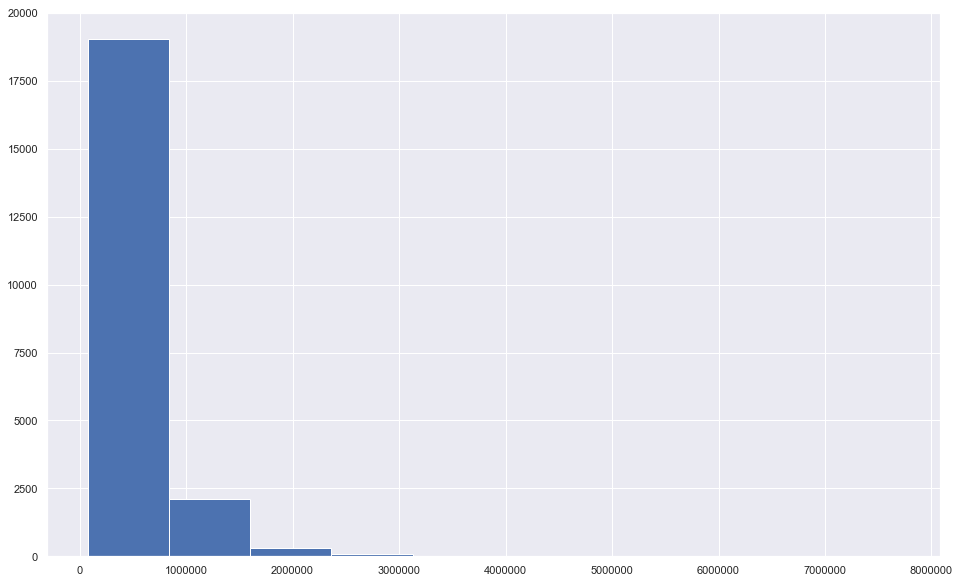

In [9]:
df_feature_add.price.hist(figsize  = [16, 10])

Let's consider evulating a log-linear relationship by adding a `'log_price'` column.

In [10]:
df_feature_add['log_price'] = np.log(df_feature_add['price'])

Taking another look at the distribution of prices after taking the log reveals that we have much closer to a normal distribution of log_price.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


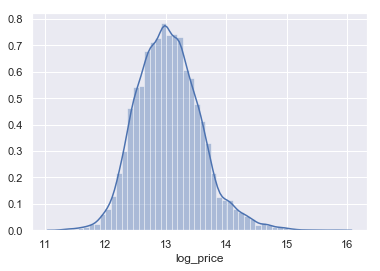

In [11]:
sns.distplot(df_feature_add.log_price);

And take another look at the scatter plots compared to the new target of `'log_price'` 

In [12]:
#scatter_y(df_feature_add, 'log_price', ncols=2, figsize=(16,45))

## Analyze Correlation between our variables

We need evaluate the correlation matrix to determine whether any of our X variables are highly correlated, which would necessitate removing at least one of them to avoid multicolinearity problems.

To make things easier, we have a function that will find any pairs of variables in the matrix with an absolute value of correlation greater than the second parameter (default = 0.75).

In [13]:
corr_pairs = findcorrpairs(df_feature_add, 0.7)
corr_pairs

,Pairs,Correlation
15,"[grade, grade_bin]",1.00
3,"[bathroom_bins, bathrooms]",0.97
1,"[log_price, price]",0.89
7,"[sqft_above, sqft_living]",0.88
22,"[has_basement, sqft_basement]",0.82
20,"[sqft_above, sqft_above_tophalf]",0.79
2,"[bathrooms, sqft_living]",0.76
6,"[grade, sqft_living]",0.76
8,"[sqft_living, sqft_living15]",0.76
10,"[grade_bin, sqft_living]",0.76


# Our Initial Regression Model

## Set-up

From our intuition about the scatter plots above, along with removing a few variables that would be correlated, we take our first shot at linear regression.

Below is our list of initial X variables to try and model upon.

Some intuitive features you would see in the listing for the home include the number of bedrooms and bathrooms and the square footage of the home and property.

In [14]:
x_list = ["bedrooms", 
          "bathrooms", 
          "sqft_above", 
          "sqft_basement", 
          "sqft_lot", 
          "sqft_living15", 
          "sqft_lot15"]

We first run the regression using stats model's OLS function.  Note that the dataframe of X variables must include a column of constants (1).  We have decided to use `'log_price'` as our target (Y).

In [15]:
X = df_feature_add.loc[:, x_list]
X = sm.add_constant(X)
Y = df_feature_add['log_price']

## Initial Model Results

The code below fits our model and sets it equal to the variable `model_init`.  We then take a look at the results with the `.summary()` method

In [16]:
model_init = sm.OLS(Y, X).fit()
model_init.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     3287.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:05:56   Log-Likelihood:                -8957.0
No. Observations:               21597   AIC:                         1.793e+04
Df Residuals:                   21589   BIC:                         1.799e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1662      0.011   1075.905      0.000      12.144      12.188
bedrooms         -0.0577      0.003    -16.510      0.000      -0.065      -0.051
bathrooms         0.0554      0.005     10.986      0.000       0.046       0.065
sqft_above        0.0003   6.01e-06     47.458      0.000       0.000       0.000
sqft_basement     0.0004   6.99e-06     51.438      0.000       0.000       0.000
sqft_lot       2.408e-07   8.68e-08      2.773      0.006    7.06e-08    4.11e-07
sqft_living15     0.0002   5.73e-06     31.259      0.000       0.000       0.000
sqft_lot15    -1.175e-06   1.33e-07     -8.866      0.000   -1.43e-06   -9.15e-07
==============================================================================
Omnibus:                       25.329   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.437
Skew:                           0.031   Prob(JB):                     1.34e-05
Kurtosis:                       2.855   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<font size="4">Not great...<br>
    Our correlation of 0.516 isn't very good. <br><br> However, the silver lining is that the distribution of residuals appears to be approximately normally distributed based on the histogram of residuals and Q-Q plot below. </font>

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


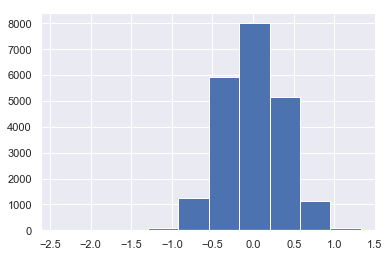

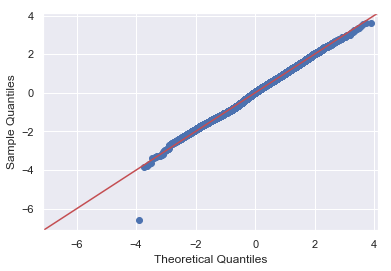

In [17]:
resid1 = model_init.resid
resid1.hist()
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig.show()

# Making our model smarter

## Removing Outliers

We observed that there were some very large outliers in the fields of `'sqft_lot'` and `'sqft_lot15'`.

Our condition below removes any outliers beyond the 99.9th percentile.

The output below the code shows that 38 total outliers were removed.

In [18]:
var_limits = {'sqft_lot': [0, .999], 
              'sqft_lot15': [0, .999]}


#df_filter = filter_df_quantiles(df_feature_add, var_limits)
df_filter = df_feature_add

## Set up data fields as Categorical to avoid treating as numbers

First we use our `set_to_categorical()` function to take the list of variables shown below and convert each to a category datatype in the dataframe.

In [19]:
categorical_columns = ['waterfront', 'view', 'condition',
                       'yr_renovated_cat', 'season', 'zipcode', 'grade']
# not in use: 'zipcode', 'grade'
set_to_categorical(df_filter, categorical_columns)

print("Categorical Variables:")
print(df_clean.dtypes[df_filter.dtypes=='category'])


Categorical Variables:
waterfront    object
view          object
condition      int64
grade          int64
zipcode        int64
dtype: object


We have made a custom function `create_dummyframe()` which generates a data frame of dummy variables for each of the variables listed in the second parameter from the original data frame.

In [20]:
df_dummy = create_dummyframe(df_filter, categorical_columns)

print('df_dummy shape: {}'.format(df_dummy.shape))
print('\nPreview:')
df_dummy.head()


df_dummy shape: (21597, 102)

Preview:


,waterfront_0.0,waterfront_1.0,waterfront_missing,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,condition_1,condition_2,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Scaling our Variables

Based on the scatterplot of possible x variables and `'log_price'` we assess that the following variables should have the log function applied in order for their relationships with `'log_price'` to be linear. 

In [21]:
log_list = ['sqft_above', 'sqft_basement',
            'sqft_living15', 'sqft_lot', 'sqft_lot15']



# avoid value of 0 in sqft_basement
df_clean['sqft_basement'] = df_clean['sqft_basement'] + 1

for i in log_list:
    try:
        logcount
    except:
        logcount = 1
        df_filter[i] = df_filter[i].apply(np.log)   #apply(lambda x: np.log(x))



To make sure no variables have any added or diminished effect simply due to the magnitude of the variable, we will standardize.

Some variables are standardized using the `MinMaxScaler()`, while others use the `StandardScaler()`.

We defaulted to using the `StandardScaler()` except for those variables that can be represented well by a specific domain.  

In this case, we thought that was appropriate for the `'date_num'` and `'yr_built'` data fields because they can be thought of as positions of dates within a specific range of time.

In [22]:
min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()


Y = df_filter['log_price']


unadj_list = ['has_basement', 'zip_highprice', 'sqft_lot', 'sqft_above', 
                 'sqft_living15', 'sqft_lot15', 'yr_built', 'historic_home', 'dist_city_center', 'bathroom_bins', 'bedrooms', 'age']

  
min_max_list = ['date_num']

std_scal_list = []

X_unadj = pd.DataFrame(columns=unadj_list)
X_min_max = pd.DataFrame(columns=min_max_list)
X_std_scal = pd.DataFrame(columns=std_scal_list)



for col_name in min_max_list:
    X_min_max[col_name] = df_filter[col_name]
    
for col_name in std_scal_list:
    X_std_scal[col_name] = df_filter[col_name]

for col_name in unadj_list:
    X_unadj[col_name] = df_filter[col_name]   


X_min_max = pd.DataFrame(data= min_max_scaler.fit_transform(X_min_max.values), columns=X_min_max.columns)

#X_std_scal = pd.DataFrame(data= standard_scaler.fit_transform(X_std_scal.values), columns=X_std_scal.columns)

X_std_scal = pd.DataFrame()


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Due to filtering, some of our indices became mismatched.  However, our rows still line up, so we reset the axes to concatenate all of our various X dataframes together into one.

In [23]:
X_min_max.reset_index(inplace=True)
X_std_scal.reset_index(inplace=True)
X_unadj.reset_index(inplace=True) 
df_dummy.reset_index(inplace=True)
Y = Y.reset_index().drop(['index'], axis=1)


X_possible = pd.concat([X_min_max, X_std_scal, X_unadj, df_dummy], axis=1)
print(X_possible.columns)

X_possible['bath_bed_ratio']=X_possible['bathroom_bins']/X_possible['bedrooms']

Index(['index', 'date_num', 'index', 'index', 'has_basement', 'zip_highprice',
       'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       ...
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13'],
      dtype='object', length=119)


We need to remove several columns.  Notably, each of our categorical column groups needs at least one removed to avoid multicolinearity issues.

In [40]:
drop_list = ['waterfront_missing', 'view_0.0', 'condition_1', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
                           'yr_renovated_cat_Never Renovated', 'yr_renovated_cat_Prior to 2000', 'yr_renovated_cat_missing',
                           'season_Winter', 'index', 'yr_built', 'date_num', 'sqft_lot', 'zipcode_98039', 'zip_highprice',
                            'waterfront_0.0', 'age', 'historic_home', 'grade_4', 'grade_12', 'grade_13',
                            'season_Fall','season_Spring', 'season_Summer']


X_model = X_possible.drop(drop_list, axis=1)

# 'zipcode_98001','waterfront_1.0', 'yr_renovated_cat_missing',
#                          'grade_3', 'grade_6', 'waterfront_0.0', 'condition_2'

X_model = sm.add_constant(X_model)

In [41]:
#X_model.dtypes

In [42]:
model_smarter = sm.OLS(Y, X_model).fit()
model_smarter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     1607.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:08:06   Log-Likelihood:                 5387.0
No. Observations:               21597   AIC:                        -1.059e+04
Df Residuals:                   21505   BIC:                            -9856.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    10.8090      0.058    187.971      0.000      10.696      10.922
has_basement                              0.1453      0.003     41.749      0.000       0.138       0.152
sqft_above                                0.4426      0.007     65.441      0.000       0.429       0.456
sqft_living15                          9.225e-05   3.35e-06     27.508      0.000    8.57e-05    9.88e-05
sqft_lot15                              9.85e-07   5.37e-08     18.358      0.000     8.8e-07    1.09e-06
dist_city_center                         -0.0119      0.001    -19.670      0.000      -0.013      -0.011
bathroom_bins                             0.0512      0.005      9.318      0.000       0.040       0.062
bedrooms                                 -0.0251      0.004     -6.409      0.000      -0.033      -0.017
waterfront_1.0                            0.4540      0.019     23.332      0.000       0.416       0.492
view_1.0                                  0.1189      0.011     11.065      0.000       0.098       0.140
view_2.0                                  0.1190      0.007     18.176      0.000       0.106       0.132
view_3.0                                  0.1957      0.009     21.951      0.000       0.178       0.213
view_4.0                                  0.3326      0.013     24.689      0.000       0.306       0.359
yr_renovated_cat_Since 2000 inclusive     0.1207      0.010     12.191      0.000       0.101       0.140
zipcode_98001                            -1.0248      0.033    -31.472      0.000      -1.089      -0.961
zipcode_98002                            -1.0239      0.034    -30.035      0.000      -1.091      -0.957
zipcode_98003                            -1.0172      0.033    -31.070      0.000      -1.081      -0.953
zipcode_98004                            -0.1669      0.029     -5.780      0.000      -0.224      -0.110
zipcode_98005                            -0.5059      0.031    -16.465      0.000      -0.566      -0.446
zipcode_98006                            -0.5798      0.028    -20.353      0.000      -0.636      -0.524
zipcode_98007                            -0.5760      0.032    -18.241      0.000      -0.638      -0.514
zipcode_98008                            -0.5542      0.030    -18.654      0.000      -0.612      -0.496
zipcode_98010                            -0.7004      0.038    -18.436      0.000      -0.775      -0.626
zipcode_98011                            -0.7537      0.031    -24.347      0.000      -0.814      -0.693
zipcode_98014                            -0.6964      0.037    -19.078      0.000      -0.768      -0.625
zipcode_98019                            -0.7457      0.034    -22.226      0.000      -0.811      -0.680
zipcode_9

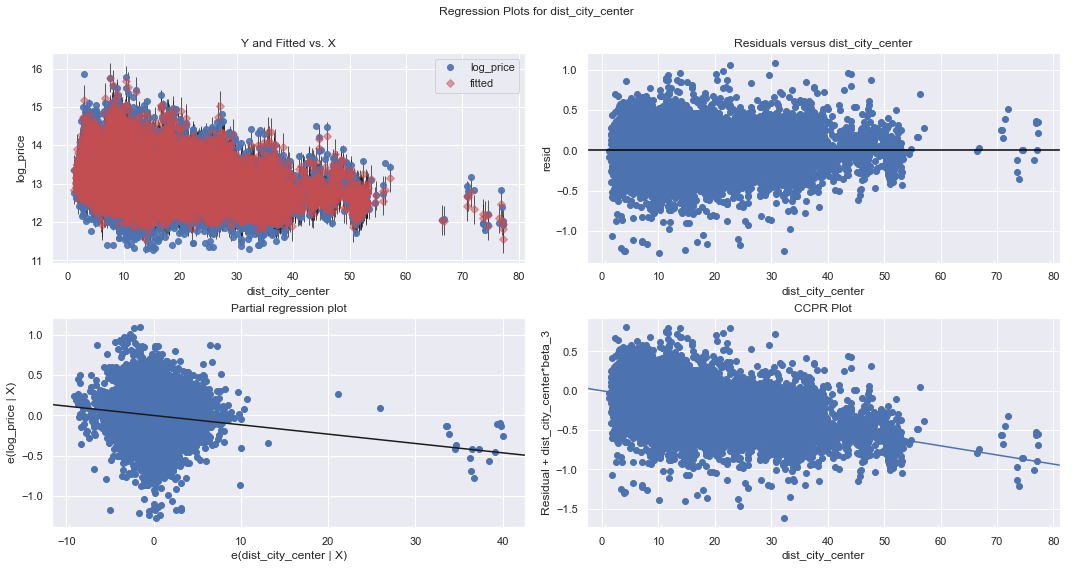

In [27]:
predicted = model_smarter.predict()
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model_smarter, "dist_city_center", fig=fig)
plt.show()
# ['sqft_above', 'dist_city_center', 'bathroom_bins', 'bedrooms'])

# K-Fold Cross Validation

In [28]:
linreg = LinearRegression()

model_kfold = KFold(n_splits=10, shuffle=True)

MSEs = cross_val_score(linreg, X_model, Y, scoring='neg_mean_squared_error', cv=model_kfold)

mean_MSE = np.mean(MSEs)

print(mean_MSE)
print(MSEs)

-0.03785948229374125
[-0.03857398 -0.03685964 -0.03587073 -0.03658571 -0.0399228  -0.03612138
 -0.04080093 -0.03782623 -0.03728805 -0.03874538]


# Selecting our best Model Variables using Recursive Feature Elimination

Through trial and error (and with the help of Douglas Adams), we decided to use 42 variables.

We select our variables using recursive feature elimination.

In [29]:
selector = RFE(linreg, n_features_to_select =90)
selector = selector.fit(X_model, Y['log_price'])
selected_X = X_model.columns[selector.support_]

df_selected = X_model.loc[:, selected_X]
df_selected = sm.add_constant(df_selected)

model = sm.OLS(Y, df_selected).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     1546.
Date:                Fri, 10 May 2019   Prob (F-statistic):               0.00
Time:                        09:05:59   Log-Likelihood:                 4819.0
No. Observations:               21597   AIC:                            -9458.
Df Residuals:                   21507   BIC:                            -8740.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    10.5984      0.059    180.590      0.000      10.483      10.713
has_basement                              0.1704      0.003     48.880      0.000       0.164       0.177
sqft_above                                0.5157      0.007     78.954      0.000       0.503       0.529
dist_city_center                         -0.0117      0.001    -18.838      0.000      -0.013      -0.010
bathroom_bins                             0.0543      0.006      9.634      0.000       0.043       0.065
bedrooms                                 -0.0313      0.004     -7.798      0.000      -0.039      -0.023
waterfront_1.0                            0.4378      0.020     21.923      0.000       0.399       0.477
view_1.0                                  0.1419      0.011     12.902      0.000       0.120       0.163
view_2.0                                  0.1439      0.007     21.585      0.000       0.131       0.157
view_3.0                                  0.2331      0.009     25.690      0.000       0.215       0.251
view_4.0                                  0.3717      0.014     27.001      0.000       0.345       0.399
yr_renovated_cat_Since 2000 inclusive     0.1094      0.010     10.769      0.000       0.089       0.129
zipcode_98001                            -1.0678      0.033    -31.966      0.000      -1.133      -1.002
zipcode_98002                            -1.0872      0.035    -31.117      0.000      -1.156      -1.019
zipcode_98003                            -1.0608      0.034    -31.588      0.000      -1.127      -0.995
zipcode_98004                            -0.1775      0.030     -5.988      0.000      -0.236      -0.119
zipcode_98005                            -0.5088      0.032    -16.131      0.000      -0.571      -0.447
zipcode_98006                            -0.5848      0.029    -19.998      0.000      -0.642      -0.527
zipcode_98007                            -0.6046      0.032    -18.659      0.000      -0.668      -0.541
zipcode_98008                            -0.5898      0.030    -19.353      0.000      -0.650      -0.530
zipcode_98010                            -0.7061      0.039    -18.117      0.000      -0.783      -0.630
zipcode_98011                            -0.7737      0.032    -24.351      0.000      -0.836      -0.711
zipcode_98014                            -0.6795      0.037    -18.196      0.000      -0.753      -0.606
zipcode_98019                            -0.7486      0.034    -21.743      0.000      -0.816      -0.681
zipcode_98022                            -0.7719      0.040    -19.113      0.000      -0.851      -0.693
zipcode_98023                            -1.0972      0.033    -33.344      0.000      -1.162      -1.033
zipcode_9

Once again, we want to check our distribution of errors and the comparison of the actual quantiles versus theoretical in the Q-Q plot

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


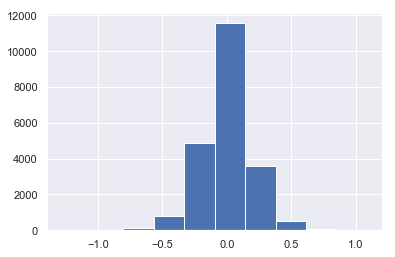

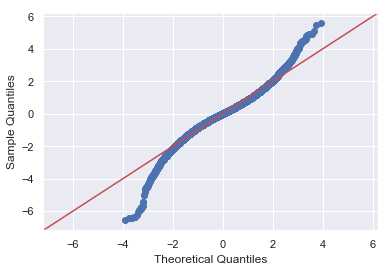

In [30]:
resid1 = model.resid
resid1.hist()

fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig.show()

Our model fitted to the target of `'log_price'`.  In order to compare how closely we matched to the actual price, we will need to take the exponential of both the actual `Y['log_price']` and the predicted values of `'log_price'`.

In [31]:
y_hat_exp = np.exp(model.predict(df_selected))
y_exp = np.exp(Y['log_price'])

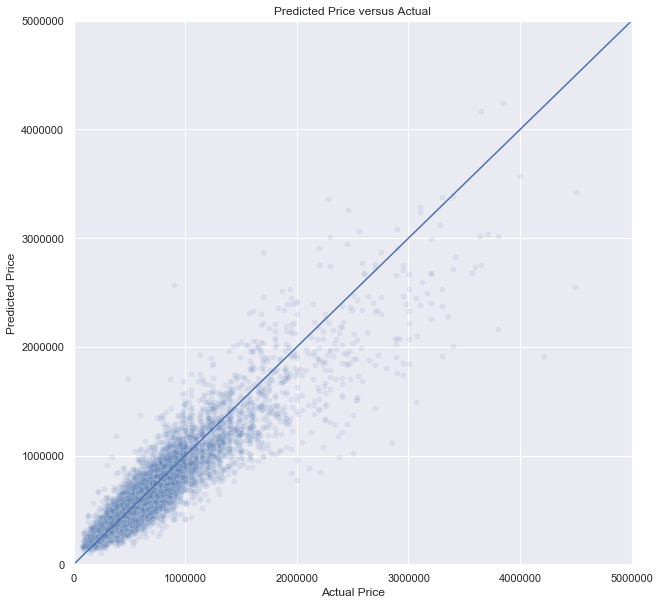

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(y_exp, y_hat_exp, alpha=0.1)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
limiter = 5000000
plt.xlim(0, 5000000)
plt.ylim(0, 5000000)
plt.title('Predicted Price versus Actual')
sns.lineplot(x=[0, 5000000], y=[0, 5000000]);

The graph above shows how the actual prices compare to the predicted prices in our data.  We would hope the reuslts would be relatively close to the line drawn by y=x.

We can also graph our residuals and basically shift this graph so that the line y=x essentially becomes the x-axis.

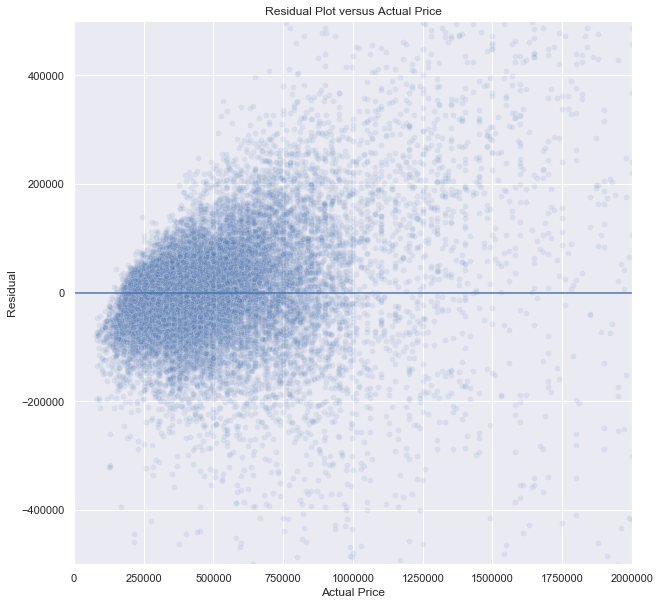

In [33]:
plt.figure(figsize=(10,10))
sns.scatterplot(y_exp, y_exp - y_hat_exp, alpha=0.1)
plt.xlabel('Actual Price')
plt.ylabel('Residual')
plt.xlim(0,2000000)
plt.ylim(-500000,500000)
plt.title('Residual Plot versus Actual Price')
sns.lineplot(x=[0,6000000], y=[0, 0]);

In [34]:
print('Average Absolute Error: ${0:.2f}'.format(np.mean(abs(y_exp - y_hat_exp))))

Average Absolute Error: $78078.07


In [35]:
print('Average Percent Error: {0:.2f}%'.format(100 * np.mean(abs(y_exp - y_hat_exp)) / y_exp.mean()))

Average Percent Error: 14.45%


In [36]:
print('Average of Absolute Error for each: {0:.2f}%'.format(100*np.mean(abs(y_exp - y_hat_exp)/y_exp)))

Average of Absolute Error for each: 14.55%


In [37]:
model_kfold = KFold(n_splits=10, shuffle=True)
MSEs = cross_val_score(linreg, df_selected , Y, scoring='neg_mean_squared_error', cv=model_kfold)
MSEs

array([-0.0375202 , -0.0379507 , -0.03608139, -0.03786184, -0.03984313,
       -0.03754257, -0.0340695 , -0.03943448, -0.03759281, -0.04076262])

In [38]:
test = df_raw.groupby('zipcode')['price'].mean()
test[test>800000]

zipcode
98004    1.356524e+06
98005    8.102897e+05
98006    8.599386e+05
98033    8.039908e+05
98039    2.161300e+06
98040    1.194874e+06
98102    8.996077e+05
98105    8.632289e+05
98109    8.800778e+05
98112    1.096239e+06
98119    8.497148e+05
Name: price, dtype: float64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


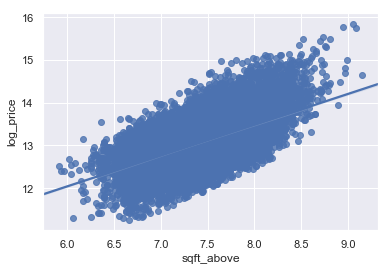

In [39]:
sns.regplot(x=X_model['sqft_above'], y=Y['log_price'], x_ci='ci', ci=99)